In [1]:
# Copyright 2021 NVIDIA Corporation. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

In [2]:
# External dependencies
import os

import cudf  # cuDF is an implementation of Pandas-like Dataframe on GPU
# import rmm

import nvtabular as nvt

from sklearn.model_selection import train_test_split

In [3]:
INPUT_DATA_DIR = os.environ.get(
    "INPUT_DATA_DIR", os.path.expanduser("~/nvt-examples/end-to-end-poc/data/")
)

## Ratings Feature Engineering

In [4]:
ratings = cudf.read_csv(os.path.join(INPUT_DATA_DIR, "ml-25m", "ratings.csv"))
ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [5]:
ratings_ds = nvt.Dataset(ratings)

In [6]:
min_day = ratings["timestamp"].min() // 86400

def create_day_column(ts, df):
    day = ts // 86400
    day = day - min_day
    return day

day_feature = ["timestamp"] >> nvt.ops.LambdaOp(create_day_column) >> nvt.ops.Rename(f=lambda x: "day")

In [7]:
def binarize_interactions(col, df):
    return col > 3.0

interaction_feature = ["rating"] >> nvt.ops.LambdaOp(binarize_interactions) >> nvt.ops.Rename(f=lambda x: "interaction")

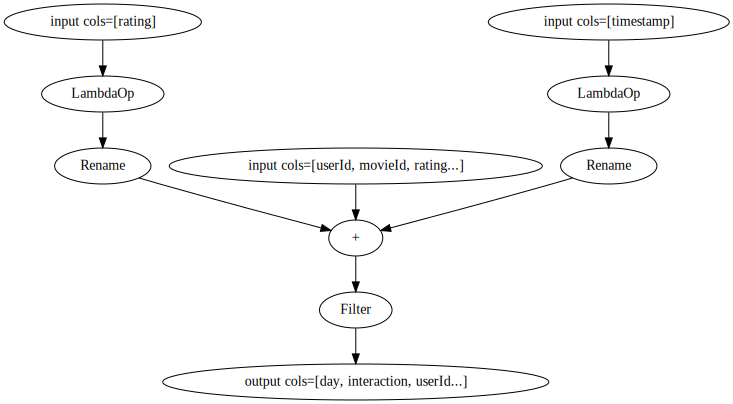

In [8]:
all_cols = day_feature + interaction_feature + ["userId", "movieId", "rating", "timestamp"]
output = all_cols >> nvt.ops.Filter(f=lambda df: df["interaction"] == True)
output.graph

In [9]:
workflow = nvt.Workflow(output)

In [10]:
%%time
workflow.fit(ratings_ds)

CPU times: user 50.8 ms, sys: 66.8 ms, total: 118 ms
Wall time: 123 ms


In [11]:
%time
ratings_features = workflow.transform(ratings_ds)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 3.34 µs


In [12]:
ratings_ddf = ratings_features.to_ddf()
ratings_ddf.head()

,day,interaction,userId,movieId,rating,timestamp
0,4146,True,1,296,5.0,1147880044
1,4146,True,1,306,3.5,1147868817
2,4146,True,1,307,5.0,1147868828
3,4146,True,1,665,5.0,1147878820
4,4146,True,1,899,3.5,1147868510


In [13]:
ratings_features.to_ddf().compute().to_parquet(os.path.join(INPUT_DATA_DIR, "ratings_features.parquet"))

In [14]:
workflow.save(os.path.join(INPUT_DATA_DIR, "ratings_features_workflow"))